In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import itertools
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data Loading and Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


In [ ]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# ---- Hourly Aggregation (mean per hour) ----
df_hourly = df["Global_active_power"].resample("H").mean()

# ---- Handle missing hours ----
df_hourly = df_hourly.interpolate()

print("Hourly series shape:", df_hourly.shape)

Hourly series shape: (17477,)


/tmp/ipython-input-1775646764.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


## Train-Test Split

In [ ]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


## Stationarity Testing (ADF Test)

In [ ]:
def adf_test(series, title="ADF Test"):
    print(f"\n----- {title} -----")
    result = adfuller(series.dropna())

    labels = ['ADF Statistic','p-value','# Lags Used','Observations Used']
    for value,label in zip(result,labels):
        print(label,' : ',value)

    if result[1] <= 0.05:
        print("=> Series is STATIONARY (no differencing needed)")
    else:
        print("=> Series is NON-STATIONARY (differencing required)")


adf_test(train, "ADF Test on Training Series")



----- ADF Test on Training Series -----
ADF Statistic  :  -12.067729113695583
p-value  :  2.387068751497141e-22
# Lags Used  :  42
Observations Used  :  13938
=> Series is STATIONARY (no differencing needed)


In [ ]:
train_diff = train.diff().dropna()

adf_test(train_diff, "ADF Test After First Difference")



----- ADF Test After First Difference -----
ADF Statistic  :  -27.64965378908722
p-value  :  0.0
# Lags Used  :  42
Observations Used  :  13937
=> Series is STATIONARY (no differencing needed)


## ACF and PACF Plots

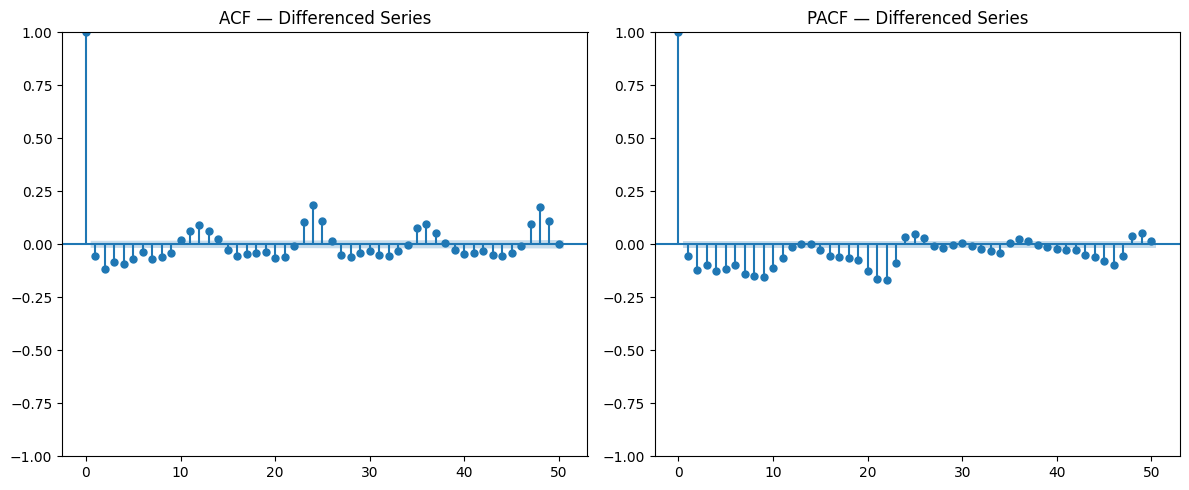

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(train_diff, ax=plt.gca(), lags=50)
plt.title("ACF — Differenced Series")

plt.subplot(1,2,2)
plot_pacf(train_diff, ax=plt.gca(), lags=50)
plt.title("PACF — Differenced Series")

plt.tight_layout()
plt.show()

## ARIMA Model Training and Prediction

In [ ]:
p, d, q = 2, 1, 2  # or your chosen order

model = ARIMA(
    train,
    order=(p,d,q),
    enforce_stationarity=False,
    enforce_invertibility=False
)

arima_fit = model.fit()

print(arima_fit.summary())

arima_predictions = arima_fit.forecast(steps=len(test))
arima_predictions = pd.Series(arima_predictions, index=test.index)

                                SARIMAX Results                                
Dep. Variable:     Global_active_power   No. Observations:                13981
Model:                  ARIMA(2, 1, 2)   Log Likelihood              -14221.716
Date:                 Sat, 27 Dec 2025   AIC                          28453.433
Time:                         05:32:00   BIC                          28491.159
Sample:                     12-16-2006   HQIC                         28465.993
                          - 07-21-2008                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3637      0.034     40.353      0.000       1.297       1.430
ar.L2         -0.5289      0.022    -24.199      0.000      -0.572      -0.486
ma.L1         -1.6013      0.036    -44.683 

## Model Evaluation

In [ ]:
mae  = mean_absolute_error(test, arima_predictions)
rmse = np.sqrt(mean_squared_error(test, arima_predictions))
mape = (abs((test - arima_predictions) / test).mean()) * 100
smape = (2 * np.mean(np.abs(arima_predictions - test) /
        (np.abs(test) + np.abs(arima_predictions)))) * 100

print("\nARIMA Model Performance (Hourly)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"sMAPE : {smape:.2f}%")


ARIMA Model Performance (Hourly)
MAE  : 0.6819
RMSE : 0.9086
MAPE : 122.07%
sMAPE : 76.54%


## Visualization of Predictions

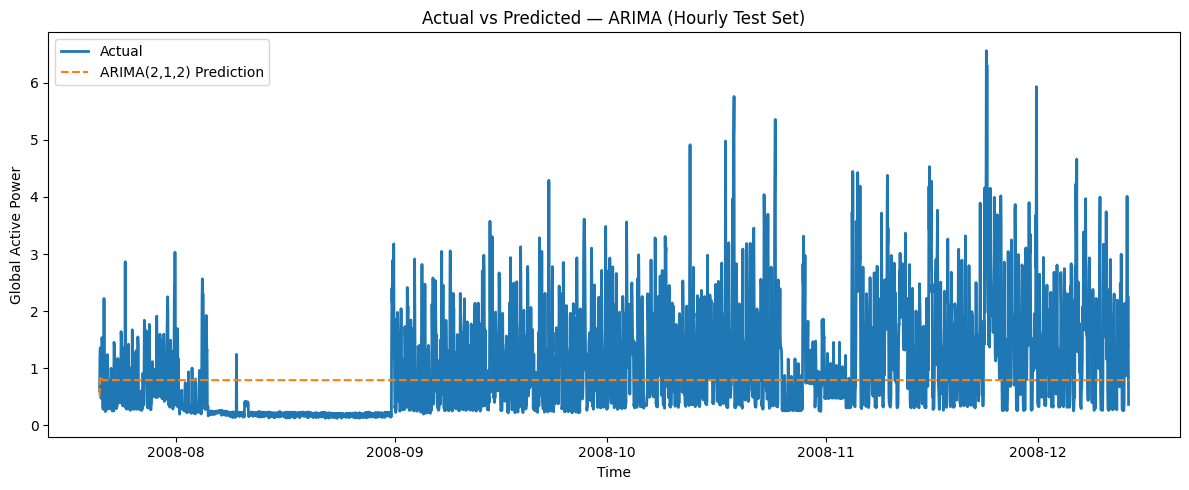

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual", linewidth=2)
plt.plot(arima_predictions,
         label=f"ARIMA({p},{d},{q}) Prediction",
         linestyle="--")

plt.title("Actual vs Predicted — ARIMA (Hourly Test Set)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.tight_layout()
plt.show()

## Results DataFrame

In [ ]:
arima_results_df = pd.DataFrame({
    "Actual": test,
    f"ARIMA({p},{d},{q})_Prediction": arima_predictions
})

arima_results_df.head()

,Actual,"ARIMA(2,1,2)_Prediction"
timestamp,,
2008-07-21 06:00:00,0.601167,0.517735
2008-07-21 07:00:00,1.161033,0.674986
2008-07-21 08:00:00,1.356633,0.777582
2008-07-21 09:00:00,1.332733,0.834332
2008-07-21 10:00:00,0.669400,0.857465
